In [1]:
! nvidia-smi

Wed Dec 20 11:57:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti     Off | 00000000:23:00.0 Off |                  N/A |
|  0%   28C    P8              17W / 310W |     16MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM


In [3]:
! pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

In [4]:
! pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [5]:
%cd {HOME}
! mkdir {HOME}/weights
%cd {HOME}/weights

! wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM
/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM/weights


In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; Exist:- ", os.path.isfile(CHECKPOINT_PATH))

/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM/weights/sam_vit_h_4b8939.pth ; Exist:-  True


In [10]:
%cd {HOME}/data #dataset

[Errno 2] No such file or directory: '/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM/data #dataset'
/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM/weights


/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM/venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [11]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM/data/BT2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

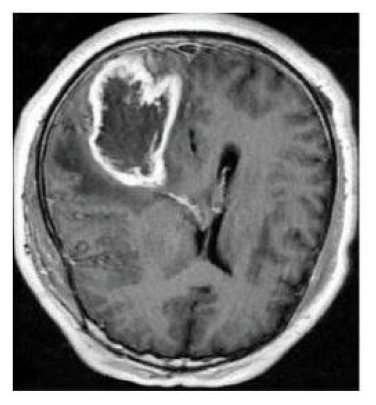

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [14]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [15]:
# Automatic mask generation
mask_generator = SamAutomaticMaskGenerator(sam)

In [16]:
import supervision as sv

image_bgr = cv2.imread('/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM/data/BT2.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [17]:
# output format
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


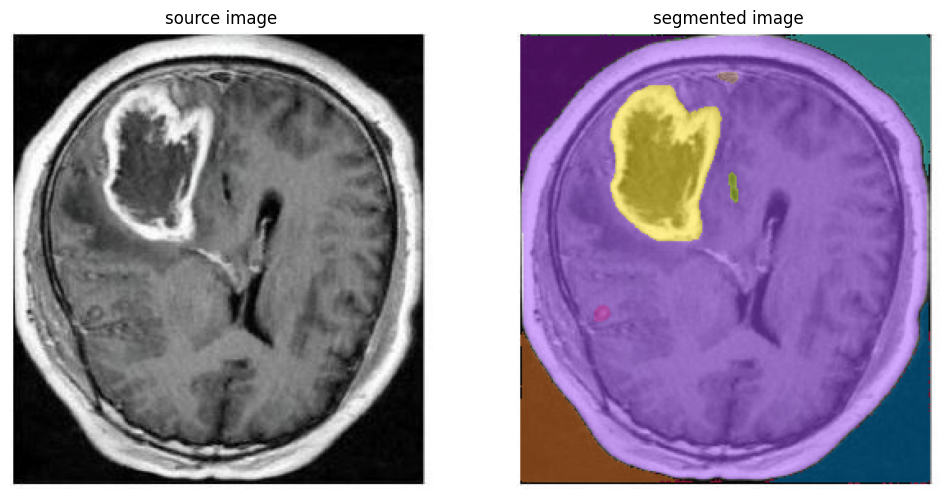

In [18]:
# Result visualization with supervision
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1,2),
    titles=['source image', 'segmented image']
)

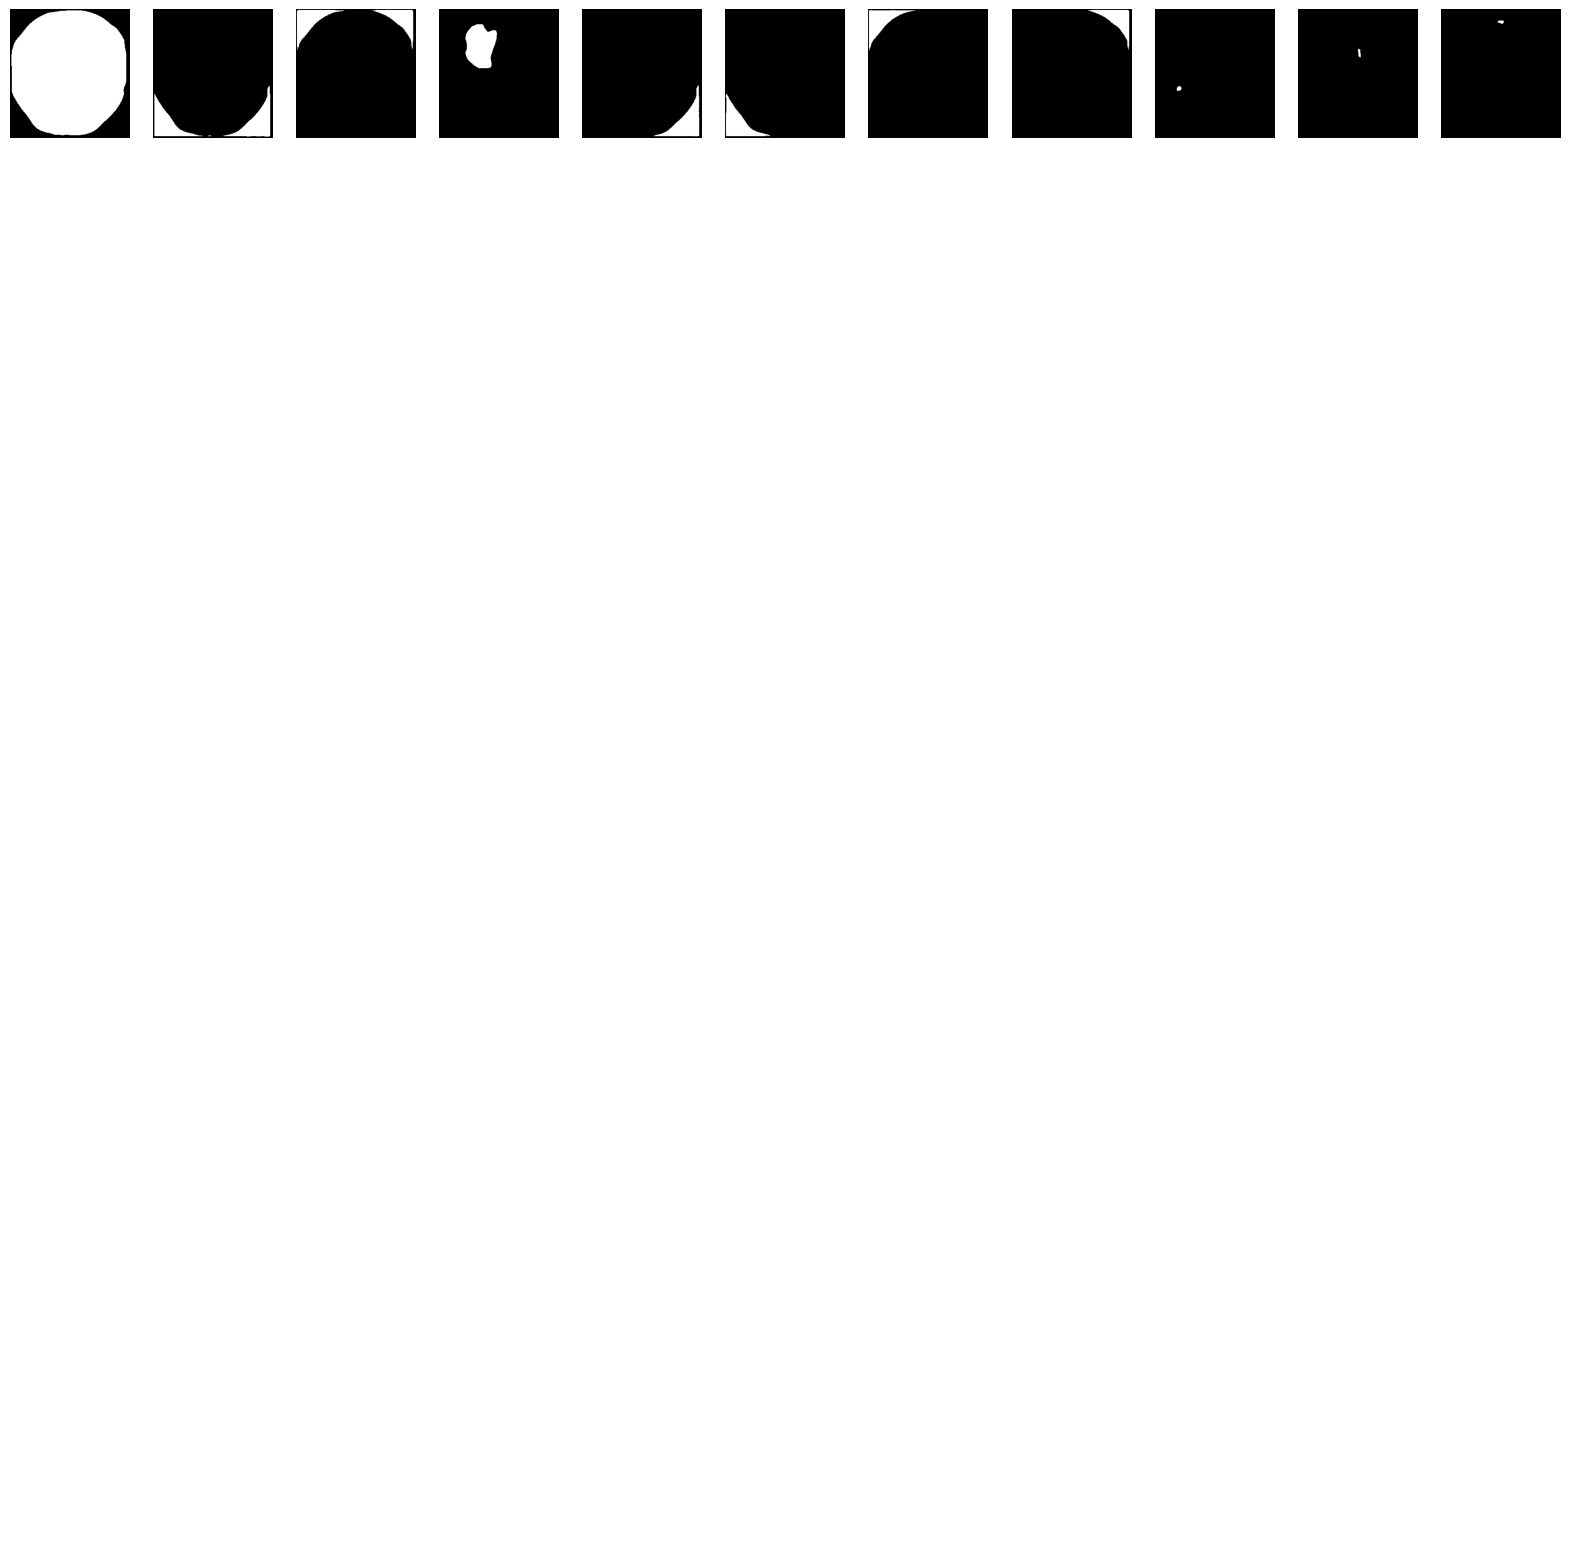

In [19]:
# segmented results (generate masks)
masks = [
    mask['segmentation']
    for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks))),
    size=(20,20)
)

In [20]:
# generate segmentation with bounding box
mask_predictor = SamPredictor(sam)

In [21]:
import os

IMAGE_NAME = "/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM/data/BT2.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [22]:
# Draw box
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [23]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [24]:
widget.bboxes

[{'x': 57, 'y': 41, 'width': 67, 'height': 90, 'label': ''}]

In [25]:
# generate masks with SAM
import numpy as np

default_box = {'x': 53, 'y': 30, 'width': 78, 'height': 107, 'label': 'YES-TUMOR'}

box = widget.bboxes[0] if widget.bboxes else default_box
label = box['label']

box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [26]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

Segmented Area: 4882 pixels


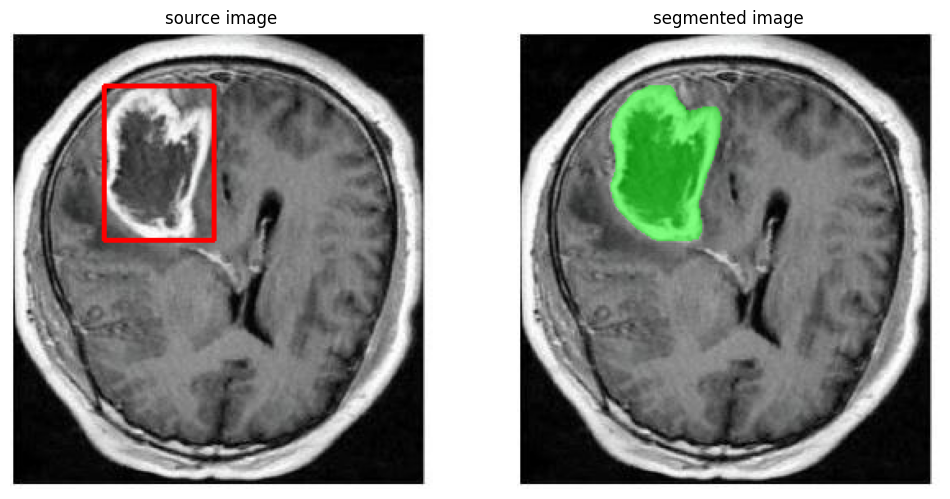

In [27]:
# result visualization with supervision
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.green(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy = sv.mask_to_xyxy(masks=masks),
    mask=masks,
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True) #else skip_label=True
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

segmented_area = detections.area[0] # added segmented area
print(f"Segmented Area: {segmented_area} pixels")

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1,2),
    titles=['source image', 'segmented image']
)

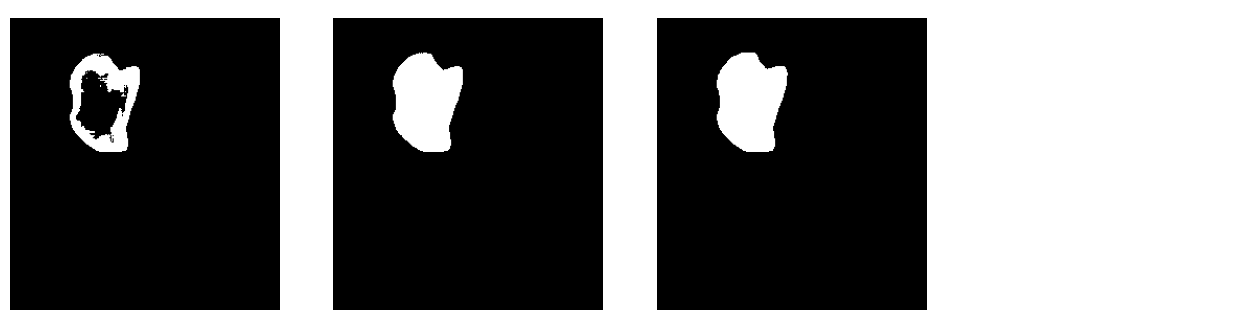

In [28]:
# Interaction with segmented result
sv.plot_images_grid(
    images=masks,
    grid_size=(1,4),
    size=(16,4)
)

In [29]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections

@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str

@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None

@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int

@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str

@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]

def load_coco_json(json_file:str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)

class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]
    
    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data,image.id)
        else:
            return None
        
    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None
    
    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])
        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

In [34]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")
dataset = project.version(1).download("coco")

/home/vlabs-004/Documents/sharan_mlops_llmops/Roboflow_SAM
visit https://app.roboflow.com/auth-cli to get your authentication token.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MRI-BRAIN-TUMOR-1 in coco:: 100%|██████████| 85/85 [00:00<00:00, 4460.69it/s]


In [35]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [36]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image in coco_data.images
]

In [37]:
CLASSES

['YES-TUMOR']

## Annotated Segmented Image Output 

In [38]:
# Single image Bounding box to mask
import random
random.seed(10)

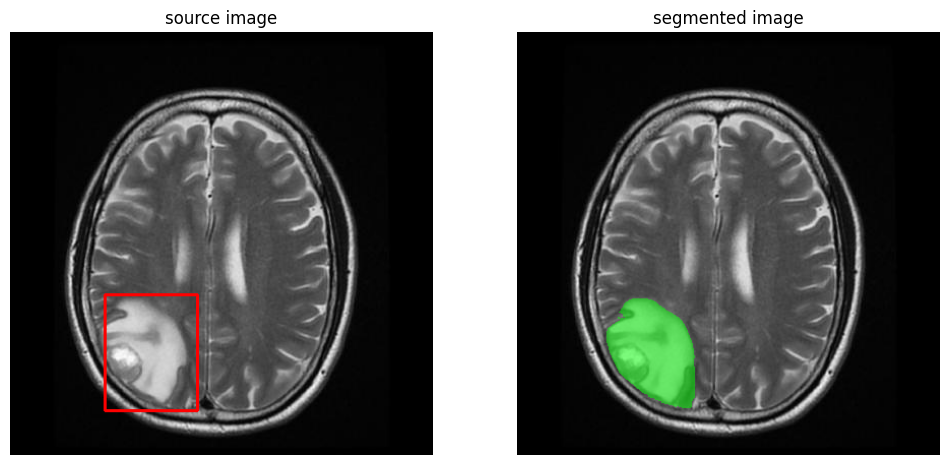

In [43]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path= EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

ground_truth.class_id = ground_truth.class_id - 1

# Load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Initiate annotator
bounding_box_annotator = sv.BoundingBoxAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.green(), color_lookup=sv.ColorLookup.INDEX)

# Annotate ground truth
labels = [
    f"{CLASSES[class_id]}"
    for _,_,_, class_id, _ in ground_truth
]
annotated_frame_ground_truth = bounding_box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth)

# Run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy = sv.mask_to_xyxy(masks=masks),
    mask=masks
)

detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1,2),
    titles=['source image', 'segmented image']
)

## Label Annotated on the Image

tumor_label:  YES-BRAIN-TUMOR, Area: 4.800480769230769 pixels


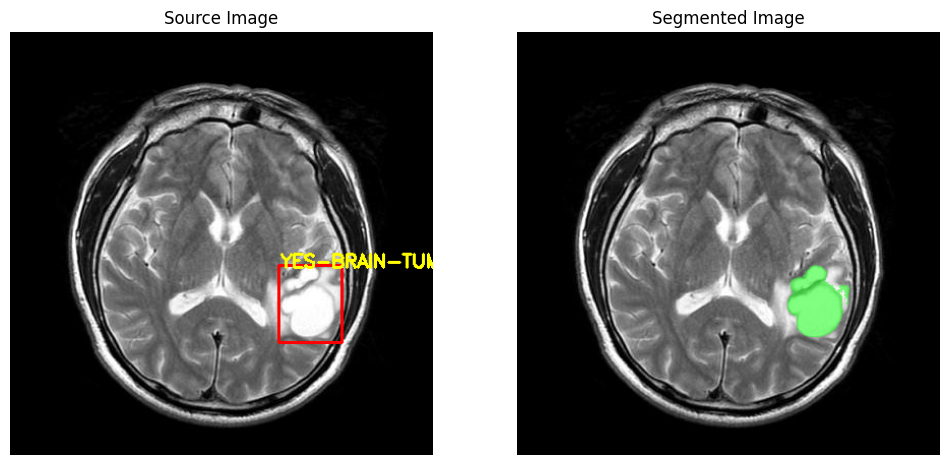

In [51]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# Load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# Load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Initiate annotator
bounding_box_annotator = sv.BoundingBoxAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.green(), color_lookup=sv.ColorLookup.INDEX)

# Annotate ground truth
annotated_frame_ground_truth = bounding_box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth)

# SAM Inference (assuming you have the mask_predictor set up)
mask_predictor.set_image(image_rgb)
masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

# Calculate the area of the segmented tumor
tumor_area = np.sum(masks[0]/len(masks[0]))  # Assuming masks[0] is the tumor mask

# Update label to include class name and area
tumor_label = f"YES-BRAIN-TUMOR, Area: {tumor_area} pixels"
print('tumor_label: ',tumor_label)

# Annotate the segmented image
detections = sv.Detections(
    xyxy = sv.mask_to_xyxy(masks=masks),
    mask=masks
)

# Find the bounding box of the tumor mask
x, y, w, h = cv2.boundingRect(masks[0].astype(np.uint8))

# Label with the coordinates of the top-left corner of the bounding box
coordinate_label = f"X: {x}, Y: {y}"

# Annotate the segmented image
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Add label with tumor size
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.6
font_color = (0, 255, 255)  # Blue color in BGR
line_type = 2


cv2.putText(annotated_frame_ground_truth, tumor_label,
            (x,y),
            font,
            font_scale,
            font_color,
            line_type)

# Display images
sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['Source Image', 'Segmented Image']
)